In [ ]:
import sys
from pathlib import Path
# Get the repository root (1 levels up from current notebook)
repo_root = Path(__file__).parent.parent if '__file__' in globals() else Path.cwd().parent
sys.path.insert(0, str(repo_root))

# import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, mean_absolute_error, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
import Template
# Definición de modulos
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling  import SMOTE, ADASYN
from sklearn.decomposition import PCA

# Instantiate the Template class
Template = Template.Template()

# Build the path to the Excel file in the repository root
data_path = os.path.join(repo_root, 'Datos1_InteraccionesNIR_clear.xlsx')
# import the data from all sheets of the Excel file


df6, df7, df8, df12, df13, df14 = [
    pd.read_excel(data_path, sheet_name=i) for i in range(6)
]


df_concatenation = pd.concat([df6, df7, df8, df12, df13, df14], ignore_index=True)

# Referencia principal de Cambio Relativo

In [ ]:
RefDf = df6[(df6['Tratamiento'] == 'Control')]

# Extract the relevant columns (from column 2 onwards)
data_cols = RefDf.iloc[:, 2:]

# Calculate the magnitude for each column
magnitudes = []

for col in data_cols.columns:
    # Get the column values
    values = data_cols[col].values
    
    # Take the first value as reference (x)
    x = values[0]
    
    # Calculate |y-x|/x, |z-x|/x, etc. for all other values
    if x != 0:  # Avoid division by zero
        differences = np.abs(values[1:] - x) / x
        # Calculate the magnitude (Euclidean norm)
        magnitude = np.sqrt(np.sum(differences**2))
    else:
        magnitude = np.nan  # Handle zero reference value
    
    magnitudes.append(magnitude)

# Create a dataframe with one row containing all magnitudes
df_mag = pd.DataFrame([magnitudes], columns=data_cols.columns)

# Display the result
print(f"Shape of result: {df_mag.shape}")
df_mag.head()

Shape of result: (1, 2151)


,350,351,352,353,354,355,356,357,358,359,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500
0,0.614958,0.47413,0.417475,0.403728,0.387654,0.411175,0.442601,0.429513,0.45711,0.553341,...,0.538078,0.541422,0.547432,0.547431,0.540409,0.539864,0.538537,0.540709,0.552268,0.548144


In [ ]:
df_mag = df_mag.transpose()

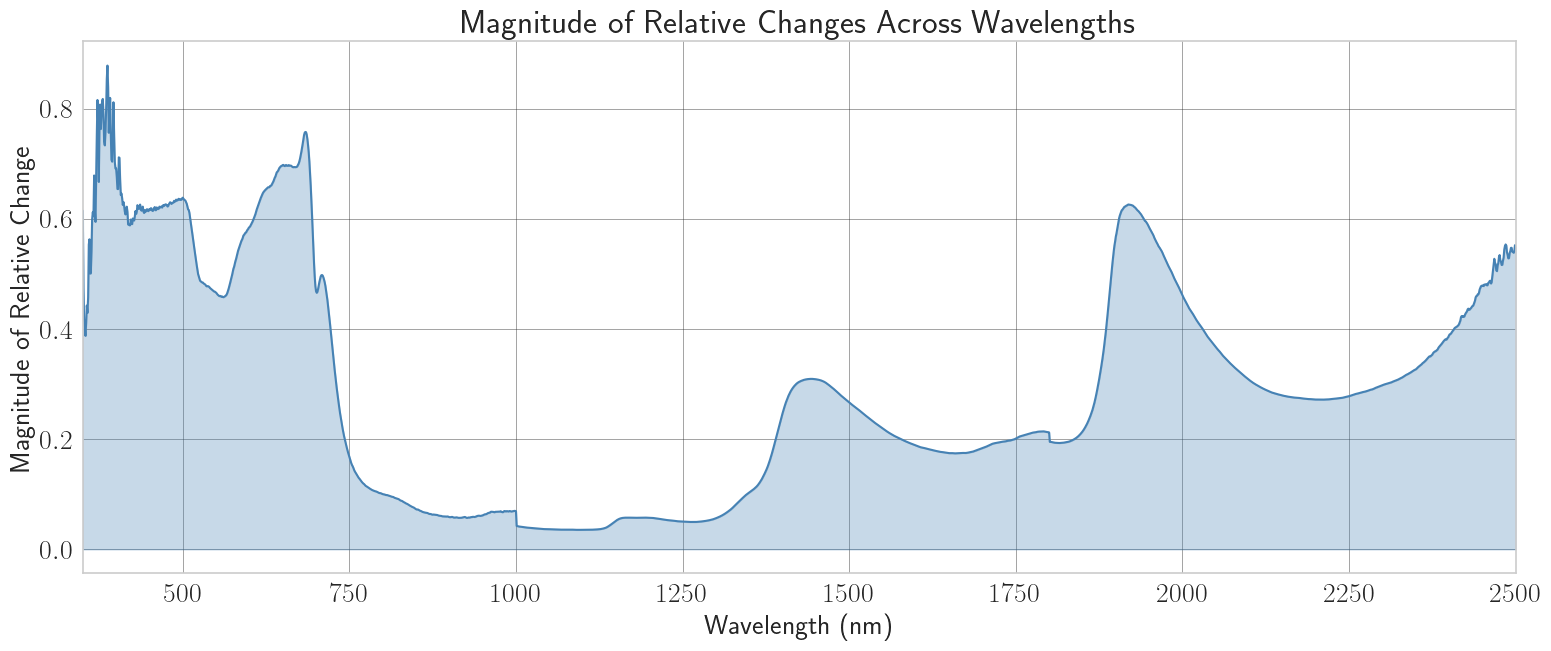

In [3]:
wavelengths = df_mag.columns.astype(float)
magnitudes_values = df_mag.iloc[0].values

# Plot 1: Line plot of magnitudes across wavelengths
plt.figure(figsize=(16, 7))
plt.plot(wavelengths, magnitudes_values, linewidth=1.5, color='steelblue')
plt.fill_between(wavelengths, magnitudes_values, alpha=0.3, color='steelblue')
plt.xlabel('Wavelength (nm)', fontsize=20)
plt.ylabel('Magnitude of Relative Change', fontsize=20)
plt.title('Magnitude of Relative Changes Across Wavelengths', fontsize=24, fontweight='bold')
plt.grid(True, alpha=0.5)
plt.xlim(wavelengths.min(), wavelengths.max())
plt.tight_layout()
plt.show()

Notar que la grafica es diferente pues ahora estamos tomando el cambio relativo entre plantas del mismo dia y no entre dias consecutivos de la misma planta


Sin embargo, los rangos importantes siguen siendo los mismos.

## Cambio relativo respecto a planta de referencia

In [7]:
all_magnitudes = []

for treatment in df_concatenation['Tratamiento'].unique():
    df_treat = df_concatenation[df_concatenation['Tratamiento'] == treatment]
    for plant_num in df_treat['Planta'].unique():
        df_plant = df_treat[df_treat['Planta'] == plant_num]
        
        # Extract the relevant columns (from column 2 onwards)
        data_cols = df_plant.iloc[:, 2:]

        # Calculate the magnitude for each column
        magnitudes = []

        for col in data_cols.columns:
            # Get the column values
            values = data_cols[col].values
            
            REF = df_mag.index[0]
            
            # Calculate |y-REF|/REF, |z-REF|/REF, etc. for all other values
            if REF != 0:  # Avoid division by zero
                differences = np.abs(values[1:] - REF) / REF
                # Calculate the magnitude (Euclidean norm)
                magnitude = np.sqrt(np.sum(differences**2))
            else:
                magnitude = np.nan  # Handle zero reference value
            
            magnitudes.append(magnitude)

        # Create a row with treatment and plant info plus magnitudes
        row_data = {'Tratamiento': treatment, 'Planta': plant_num}
        row_data.update({col: mag for col, mag in zip(data_cols.columns, magnitudes)})
        
        all_magnitudes.append(row_data)

# Create the final dataframe with all magnitudes
df_all_magnitudes = pd.DataFrame(all_magnitudes)

# Display the result
print(f"Final shape: {df_all_magnitudes.shape}")
print(f"Treatments: {df_all_magnitudes['Tratamiento'].unique()}")
print(f"Number of plants: {len(df_all_magnitudes)}")
df_all_magnitudes.head()

Final shape: (119, 2153)
Treatments: ['Control' 'Ralstonia' 'E_Hidrico' 'Ral_EH']
Number of plants: 119


,Tratamiento,Planta,350,351,352,353,354,355,356,357,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500
0,Control,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Control,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Control,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Control,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Control,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
